In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from pdf2image import convert_from_path
from scipy.stats import betabinom

module_path = os.path.abspath(os.pardir)
sys.path.append(module_path)
from plot_utils import pca_plot, sentiments_plot, smoothed_df, stacked_plot, topic_plot

In [2]:
# where to store the images
images_path = os.path.join('..', '..', 'report', 'images')

## 1) Topics

In [3]:
df = pd.read_csv('transformed_data.csv', index_col='id', parse_dates=['date'])
df.sort_values(by='date', inplace=True)
df.head()

,date,party,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8
id,,,,,,,,,,,
DE-0190001007,2017-10-24,DIE LINKE,0.000540,0.072428,0.000540,0.000540,0.723960,0.182041,0.018873,0.000540,0.000540
DE-0190001008,2017-10-24,CDU/CSU,0.000505,0.000505,0.029021,0.000505,0.967441,0.000505,0.000505,0.000506,0.000505
DE-0190001010,2017-10-24,BÜNDNIS 90/DIE GRÜNEN,0.000520,0.000519,0.028013,0.000519,0.968350,0.000520,0.000520,0.000519,0.000519
DE-0190002065,2017-11-21,FDP,0.000695,0.000695,0.063158,0.000695,0.000695,0.000695,0.042173,0.385159,0.506036
DE-0190002066,2017-11-21,DIE LINKE,0.000441,0.019499,0.462975,0.000441,0.099124,0.000441,0.000441,0.000441,0.416196


### 1.1) Summary statistics

In [4]:
df['party'].value_counts()

CDU/CSU                  2101
SPD                      1547
AfD                      1285
BÜNDNIS 90/DIE GRÜNEN    1188
FDP                      1186
DIE LINKE                1163
Name: party, dtype: int64

In [5]:
df.shape

(8470, 11)

In [6]:
df[['date', 'party']].groupby('party')['date'].nunique()

party
AfD                      198
BÜNDNIS 90/DIE GRÜNEN    193
CDU/CSU                  203
DIE LINKE                190
FDP                      189
SPD                      195
Name: date, dtype: int64

In [7]:
df['date'].nunique()

207

In [8]:
df[['date', 'party']].groupby('party')['date'].nunique()/df['date'].nunique()

party
AfD                      0.956522
BÜNDNIS 90/DIE GRÜNEN    0.932367
CDU/CSU                  0.980676
DIE LINKE                0.917874
FDP                      0.913043
SPD                      0.942029
Name: date, dtype: float64

### 1.2) Analyze topics

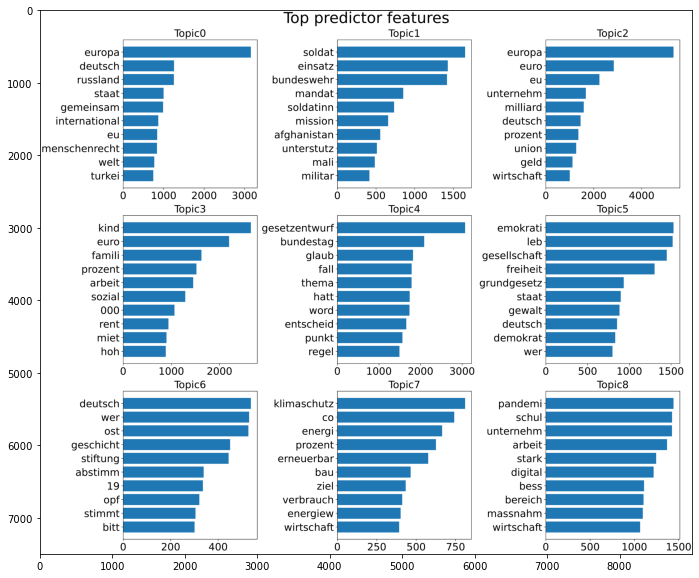

In [9]:
img = convert_from_path('topics_words.pdf', 500)[0]
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(img)

In [10]:
columns_mapper = {
    'Topic0': 'International',
    'Topic1': 'Military',
    'Topic2': 'EU/Economy',
    'Topic3': 'Social',
    'Topic4': 'Decisions/Law',
    'Topic5': 'Democracy/Freedom',
    'Topic6': 'German History',
    'Topic7': 'Ecology',
    'Topic8': 'Health/Pandemic',
}
n_topics = len(columns_mapper)

In [11]:
df.rename(columns=columns_mapper, inplace=True)

In [12]:
df.describe()

,International,Military,EU/Economy,Social,Decisions/Law,Democracy/Freedom,German History,Ecology,Health/Pandemic
count,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000
mean,0.087238,0.052928,0.100198,0.129563,0.233333,0.134542,0.026388,0.051821,0.183989
std,0.189660,0.162312,0.186119,0.220128,0.243029,0.213325,0.098461,0.135165,0.244577
min,0.000121,0.000148,0.000176,0.000148,0.000121,0.000159,0.000121,0.000176,0.000180
25%,0.000515,0.000477,0.000545,0.000542,0.000800,0.000562,0.000481,0.000496,0.000601
50%,0.000704,0.000618,0.000806,0.000923,0.166055,0.006948,0.000621,0.000658,0.059373
75%,0.055772,0.001482,0.113553,0.169415,0.378808,0.186361,0.001659,0.018530,0.308603
max,0.997509,0.997653,0.997487,0.997495,0.997529,0.997466,0.998182,0.993262,0.996868


### 1.3) Grouped parties

In [13]:
# Smoothe timeseries
grouped_df = df.groupby('date').mean()
window = 11
std = 3
rolling_grouped_df = smoothed_df(grouped_df, window=window, std=std)
rolling_grouped_df

,International,Military,EU/Economy,Social,Decisions/Law,Democracy/Freedom,German History,Ecology,Health/Pandemic
date,,,,,,,,,
2017-10-24,0.136462,0.161770,0.093438,0.022600,0.351886,0.106333,0.011336,0.028447,0.087728
2017-11-21,0.139228,0.159333,0.093966,0.041478,0.312889,0.118722,0.011988,0.027888,0.094508
2017-11-22,0.151306,0.149839,0.105168,0.050165,0.271494,0.130888,0.014802,0.027225,0.099114
2017-12-12,0.149812,0.135431,0.139258,0.058664,0.236564,0.138726,0.016317,0.025939,0.099289
2017-12-13,0.154334,0.116860,0.157874,0.072572,0.206208,0.146353,0.019307,0.024419,0.102074
...,...,...,...,...,...,...,...,...,...
2021-06-11,0.076694,0.079113,0.086503,0.092959,0.253646,0.137670,0.041058,0.039539,0.192816
2021-06-23,0.070240,0.070267,0.094461,0.093624,0.252075,0.135840,0.038384,0.037654,0.207456
2021-06-24,0.069444,0.068439,0.100303,0.092695,0.243536,0.138271,0.036784,0.034791,0.215736


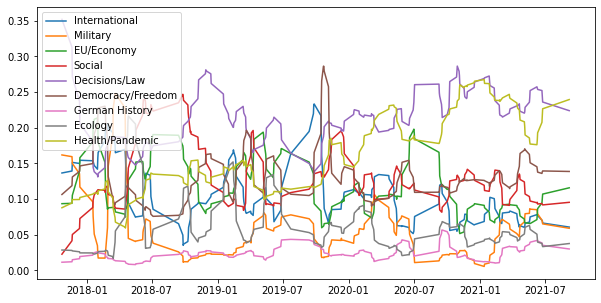

In [14]:
# Visualize topic evolution
fig, ax = plt.subplots(figsize=(10, 5))
for topic_col in rolling_grouped_df.columns:
    ax.plot(rolling_grouped_df.index.values, rolling_grouped_df[topic_col].values, label=topic_col)
ax.legend()

C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3497776500.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


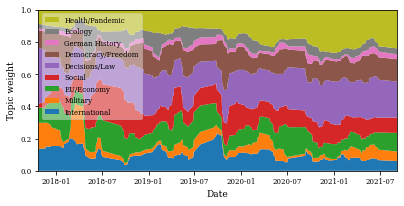

In [15]:
# Stacked topics
fig = stacked_plot(rolling_grouped_df)
fig.show()
fig.savefig(os.path.join(images_path, 'stacked_area_plot.pdf'), bbox_inches='tight')

C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/2249322385.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


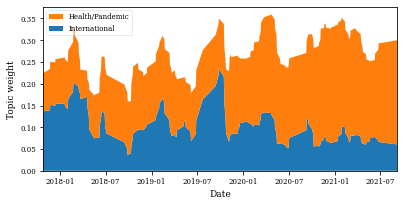

In [16]:
# Plot just a few topics (better to see the behavior of individual topics to each other)
topic_cols=['International', 'Health/Pandemic']
fig = stacked_plot(rolling_grouped_df, topic_cols)
fig.show()
fig.savefig(os.path.join(images_path, f'stacked_area_plot_{"_".join([t.replace("/", "-") for t in topic_cols])}.pdf'), bbox_inches='tight')

C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3061372699.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3061372699.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3061372699.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3061372699.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3061372699.py:4: UserWarning: Matplotlib is currently using module

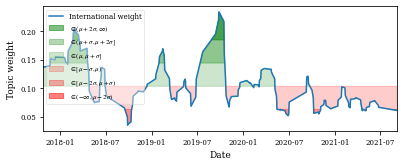

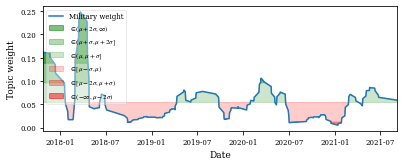

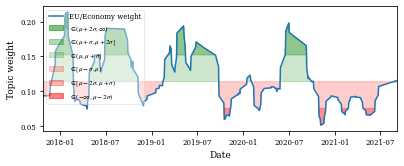

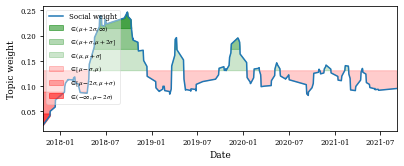

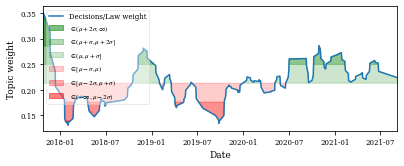

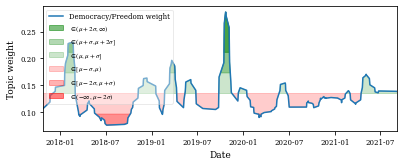

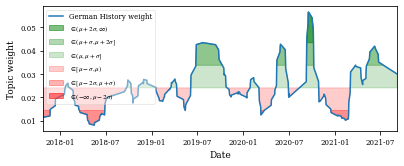

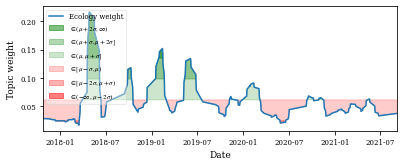

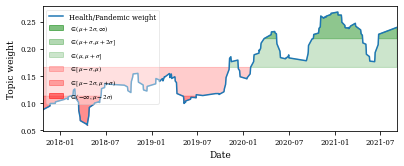

In [17]:
# Plot single topic evolution
for topic in columns_mapper.values():
    fig = topic_plot(rolling_grouped_df, topic)
    fig.show()
    fig.savefig(os.path.join(images_path, f'{topic.replace("/", "-")}.pdf'), bbox_inches='tight')

### 1.4) Parties differences

In [18]:
df.groupby('party').mean()

,International,Military,EU/Economy,Social,Decisions/Law,Democracy/Freedom,German History,Ecology,Health/Pandemic
party,,,,,,,,,
AfD,0.085626,0.047221,0.123304,0.102370,0.216955,0.209124,0.018605,0.064128,0.132667
BÜNDNIS 90/DIE GRÜNEN,0.091877,0.056833,0.089866,0.122385,0.221082,0.120718,0.033616,0.062877,0.200746
CDU/CSU,0.086900,0.063361,0.090994,0.120425,0.265963,0.111355,0.017526,0.044452,0.199024
DIE LINKE,0.103902,0.039390,0.103993,0.160943,0.186655,0.144863,0.050982,0.048467,0.160805
FDP,0.084176,0.055731,0.109599,0.132098,0.244666,0.107238,0.028578,0.049948,0.187967
SPD,0.075295,0.048530,0.091382,0.144538,0.238433,0.127872,0.019168,0.047072,0.207711


In [19]:
df.groupby('party').agg(['mean', 'std', 'median'])

International                      Military            \
                               mean       std    median      mean       std   
party                                                                         
AfD                        0.085626  0.180530  0.000713  0.047221  0.142469   
BÜNDNIS 90/DIE GRÜNEN      0.091877  0.189786  0.000783  0.056833  0.163862   
CDU/CSU                    0.086900  0.189990  0.000614  0.063361  0.183514   
DIE LINKE                  0.103902  0.213251  0.000772  0.039390  0.124746   
FDP                        0.084176  0.188767  0.000720  0.055731  0.173156   
SPD                        0.075295  0.177268  0.000658  0.048530  0.161467   

                                EU/Economy                        Social  ...  \
                         median       mean       std    median      mean  ...   
party                                                                     ...   
AfD                    0.000601   0.123304  0.199410  0.009541  0.102370  ...   
BÜNDNIS 90/DIE GRÜNEN  0.000690   0.089866  0.179785  0.000809  0.122385  ...   
CDU/CSU                0.000553   0.090994  0.175063  0.000691  0.120425  ...   
DIE LINKE              0.000678   0.103993  0.186183  0.001020  0.160943  ...   
FDP                    0.000676   0.109599  0.198957  0.000862  0.132098  ...   
SPD                    0.000598   0.091382  0.181926  0.000717  0.144538  ...   

                      Democracy/Freedom German History                      \
                                 median           mean       std    median   
party                                                                        
AfD                            0.127515       0.018605  0.049560  0.000608   
BÜNDNIS 90/DIE GRÜNEN          0.001278       0.033616  0.125222  0.000678   
CDU/CSU                        0.000756       0.017526  0.058806  0.000551   
DIE LINKE                      0.035913       0.050982  0.156674  0.000704   
FDP                            0.000893       0.028578  0.116008  0.000662   
SPD                            0.000950       0.019168  0.069689  0.000601   

                        Ecology                     Health/Pandemic            \
                           mean       std    median            mean       std   
party                                                                           
AfD                    0.064128  0.150438  0.000658        0.132667  0.201188   
BÜNDNIS 90/DIE GRÜNEN  0.062877  0.149119  0.000739        0.200746  0.264458   
CDU/CSU                0.044452  0.123190  0.000582        0.199024  0.252118   
DIE LINKE              0.048467  0.129236  0.000704        0.160805  0.230731   
FDP                    0.049948  0.133467  0.000682        0.187967  0.244917   
SPD                    0.047072  0.130628  0.000629        0.207711  0.253662   

                                 
                         median  
party                            
AfD                    0.002585  
BÜNDNIS 90/DIE GRÜNEN  0.063345  
CDU/CSU                0.080017  
DIE LINKE              0.035947  
FDP                    0.065587  
SPD                    0.096079  

[6 rows x 27 columns]

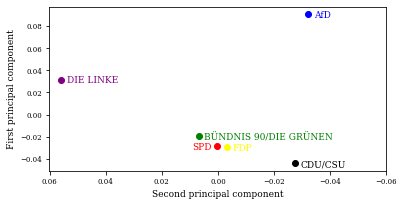

In [20]:
# PCA
fig, pca = pca_plot(df)
fig.savefig(os.path.join(images_path, 'pca.pdf'), bbox_inches='tight')

In [21]:
axis0 = [list(columns_mapper.values())[i] for i in np.argsort(np.abs(pca.components_[0]))[::-1]]
axis1= [list(columns_mapper.values())[i] for i in np.argsort(np.abs(pca.components_[1]))[::-1]]

In [22]:
axis0

['Democracy/Freedom',
 'Health/Pandemic',
 'Decisions/Law',
 'EU/Economy',
 'Military',
 'Social',
 'Ecology',
 'International',
 'German History']

In [23]:
axis1

['Decisions/Law',
 'Social',
 'German History',
 'Democracy/Freedom',
 'International',
 'Military',
 'EU/Economy',
 'Ecology',
 'Health/Pandemic']

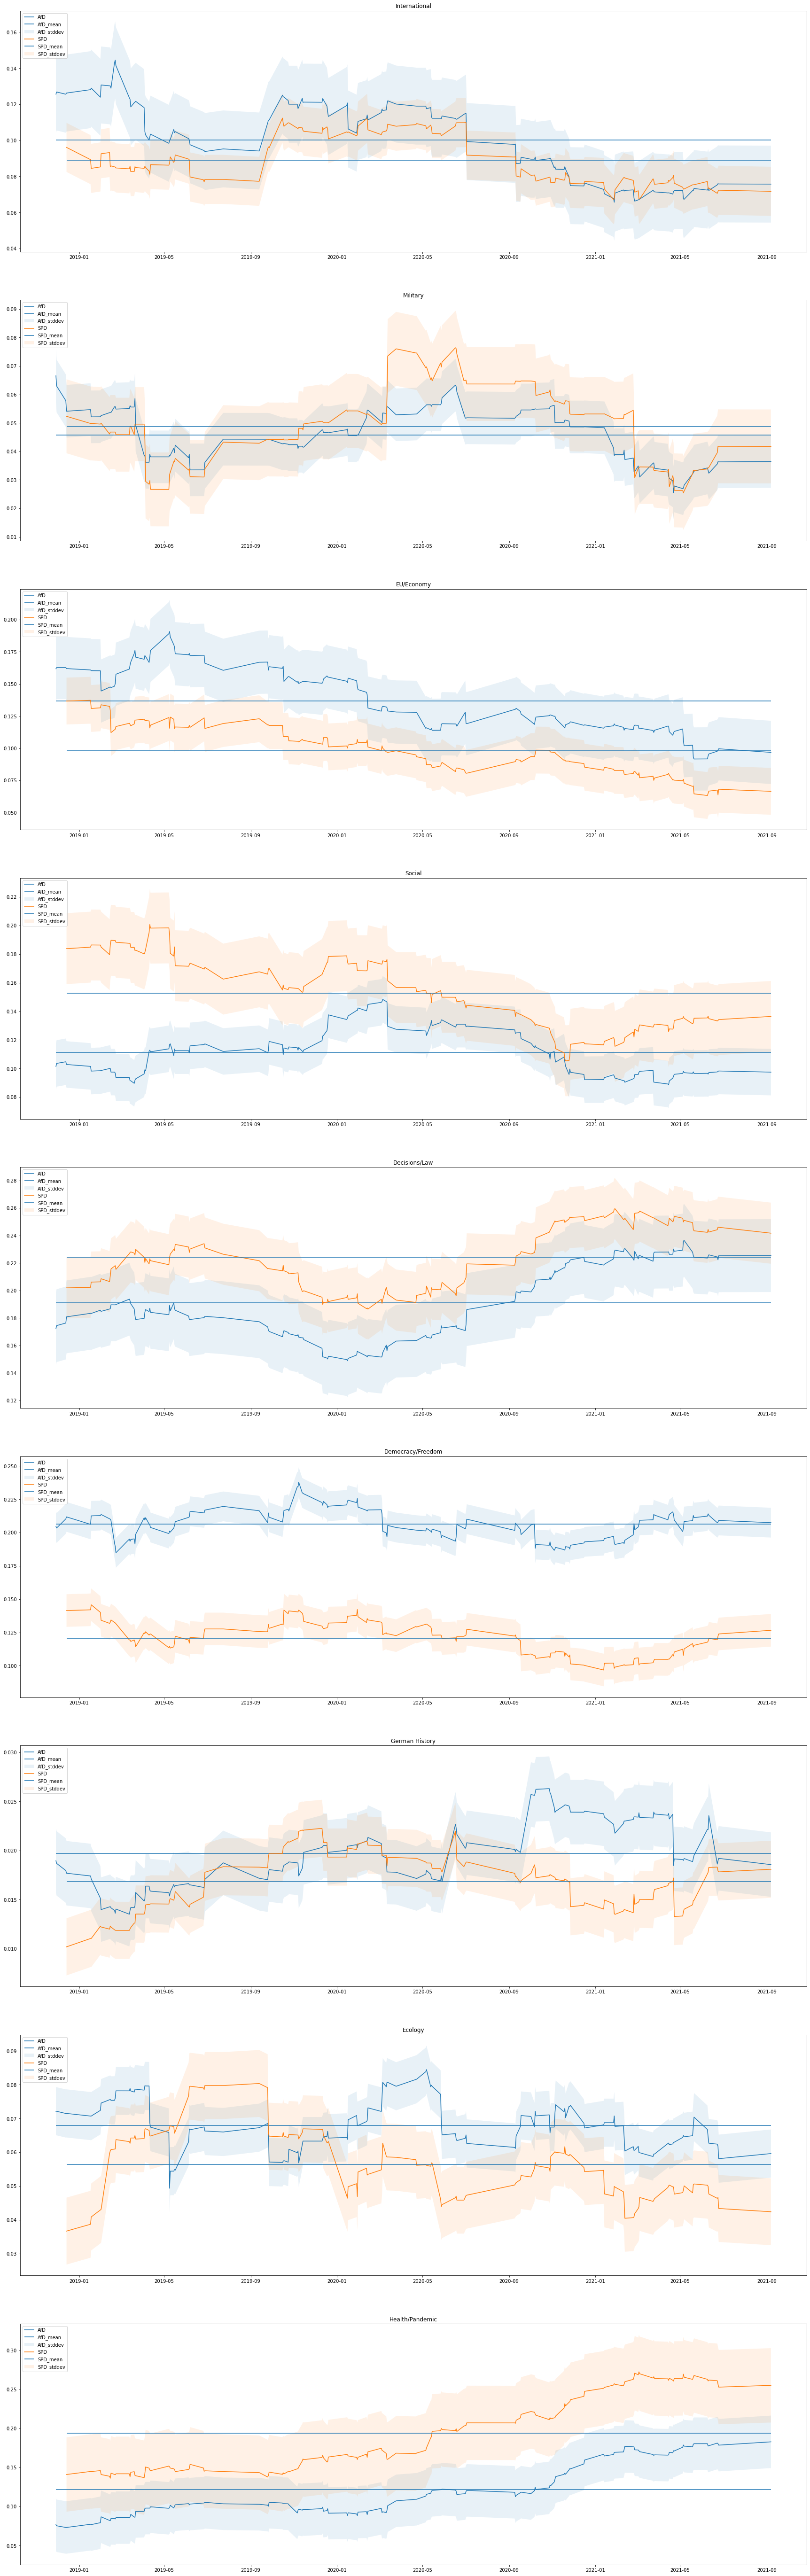

In [24]:
#TODO
#weiß ned ob hier mean und std sinn macht... kann man ja auch schnell rausnehmen

fig, ax = plt.subplots(9, figsize=(30, 100))
#parties = df['party'].unique()
parties = ['AfD','SPD']

n_days = 50

for topic_col, axis in zip(columns_mapper.values(), ax):
    for party in parties:
        data = df[df['party'] == party]
        axis.plot(
            data['date'].unique()[n_days:],
            data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days),
            label=party)
        #mean
        axis.hlines(data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days).mean(), xmin=data['date'].unique()[n_days:].min(), xmax=data['date'].unique()[n_days:].max(),label=party+'_mean')
        #stddev
        std=data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days).std()
        axis.fill_between(data['date'].unique()[n_days:], data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days)-std, data.groupby('date').mean()[topic_col].rolling(n_days).mean().tail(-n_days)+std,alpha=0.1,label=party+'_stddev')
    axis.legend(loc='upper left')
    axis.set_title(topic_col)
    
    
    
    """
ax.hlines(rolling_df[topic].values.mean(), xmin=rolling_df.index.values.min() , xmax = rolling_df.index.values.max(), color='k', label = 'mean')
#stddev - vielleicht mit gaussion process regression?
std = rolling_df[topic].values.std()
ax.fill_between(rolling_df.index.values, rolling_df[topic].values -std, rolling_df[topic].values+std, color='grey', alpha=0.2)
"""

## 2) Sentiment analysis

In [25]:
sentiments = pd.read_csv('sentiments_data.csv', index_col='id')
sentiments.head()

,date,party,sentiment
id,,,
DE-0190001007,2017-10-24,DIE LINKE,negative
DE-0190001008,2017-10-24,CDU/CSU,neutral
DE-0190001010,2017-10-24,BÜNDNIS 90/DIE GRÜNEN,negative
DE-0190002005,2017-11-21,CDU/CSU,neutral
DE-0190002015,2017-11-21,AfD,neutral


### 2.1) Summary statistics

In [26]:
sentiments['sentiment'].value_counts()

neutral     7293
negative    1179
positive      13
Name: sentiment, dtype: int64

In [27]:
sentiments.groupby(['sentiment', 'party']).count()

date
sentiment party                      
negative  AfD                     283
          BÜNDNIS 90/DIE GRÜNEN   216
          CDU/CSU                 137
          DIE LINKE               247
          FDP                     160
          SPD                     136
neutral   AfD                    1002
          BÜNDNIS 90/DIE GRÜNEN   971
          CDU/CSU                1962
          DIE LINKE               917
          FDP                    1028
          SPD                    1413
positive  AfD                       2
          BÜNDNIS 90/DIE GRÜNEN     3
          CDU/CSU                   6
          SPD                       2

In [28]:
sentiments_mapper = {'negative': -1, 'neutral': 0, 'positive': 1}
sentiments['sentiment_num'] = sentiments['sentiment'].apply(lambda s: sentiments_mapper[s])
df['topic'] = df[columns_mapper.values()].idxmax(axis=1)
df['topic'].value_counts()

Decisions/Law        1976
Health/Pandemic      1686
Social               1128
Democracy/Freedom    1042
EU/Economy            797
International         786
Military              508
Ecology               416
German History        131
Name: topic, dtype: int64

### 2.2) Time series visualization

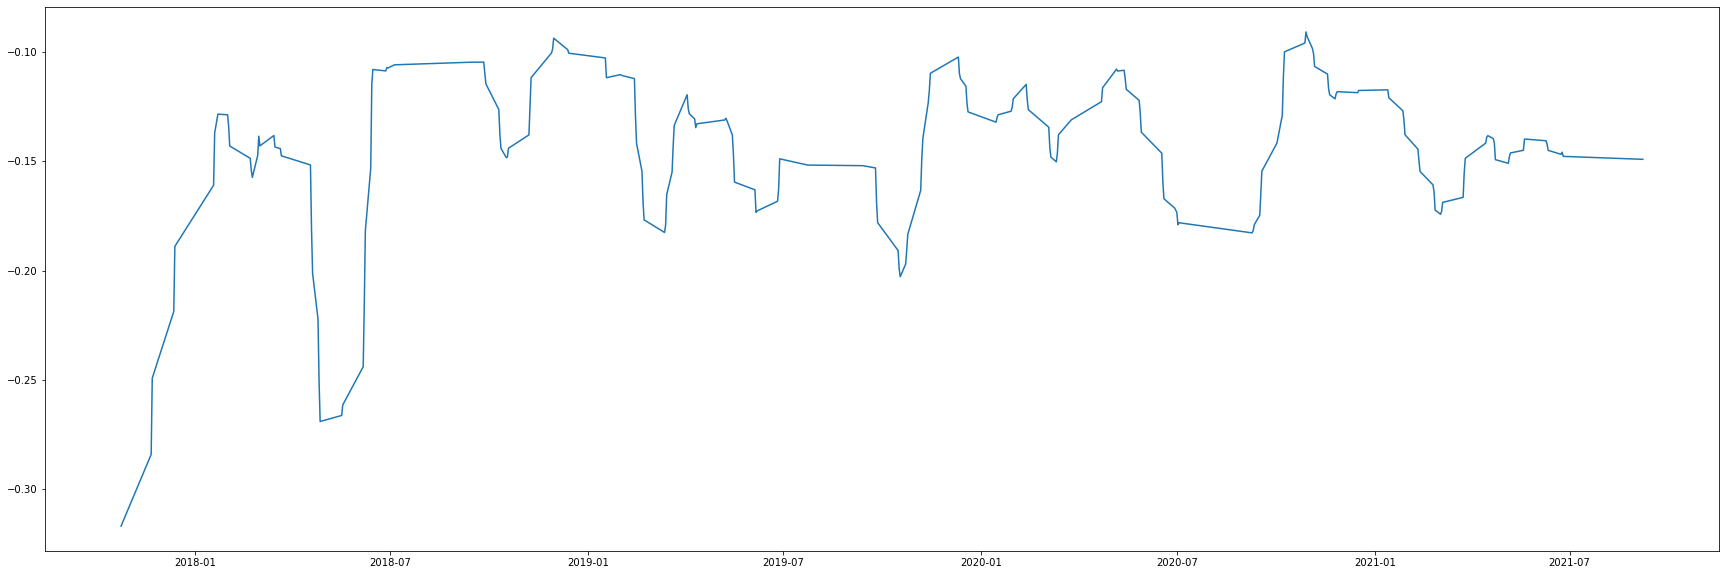

In [29]:
window = 11
std = 3
merged_df = pd.merge(df, sentiments[['sentiment_num', 'sentiment']], left_on='id', right_on='id')
grouped_df = merged_df.groupby('date').mean()
rolling_grouped_df = smoothed_df(grouped_df, window=window, std=std)

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(rolling_grouped_df.index.values, rolling_grouped_df['sentiment_num'].values)

Text(0.5, 1.0, 'Sentiments by party')

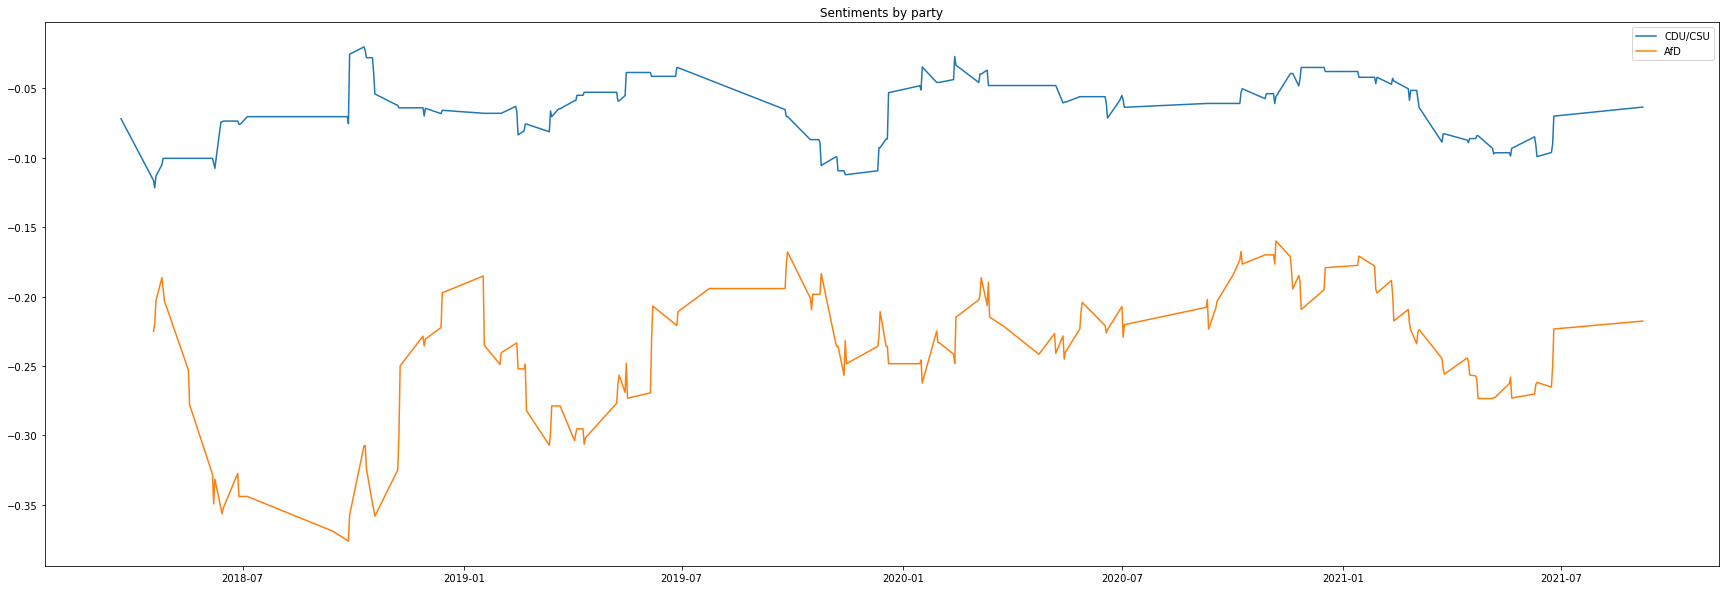

In [30]:
fig, ax = plt.subplots(figsize=(30, 10))
parties = df['party'].unique()
parties = ['CDU/CSU', 'AfD']

n_days = 20

for party in parties:
    data = merged_df[merged_df['party'] == party]
    ax.plot(
        data['date'].unique()[n_days:],
        data.groupby('date').mean()['sentiment_num'].rolling(n_days).mean().tail(-n_days),
        label=party)
ax.legend()
ax.set_title('Sentiments by party')

Text(0.5, 1.0, 'Sentiments by topic')

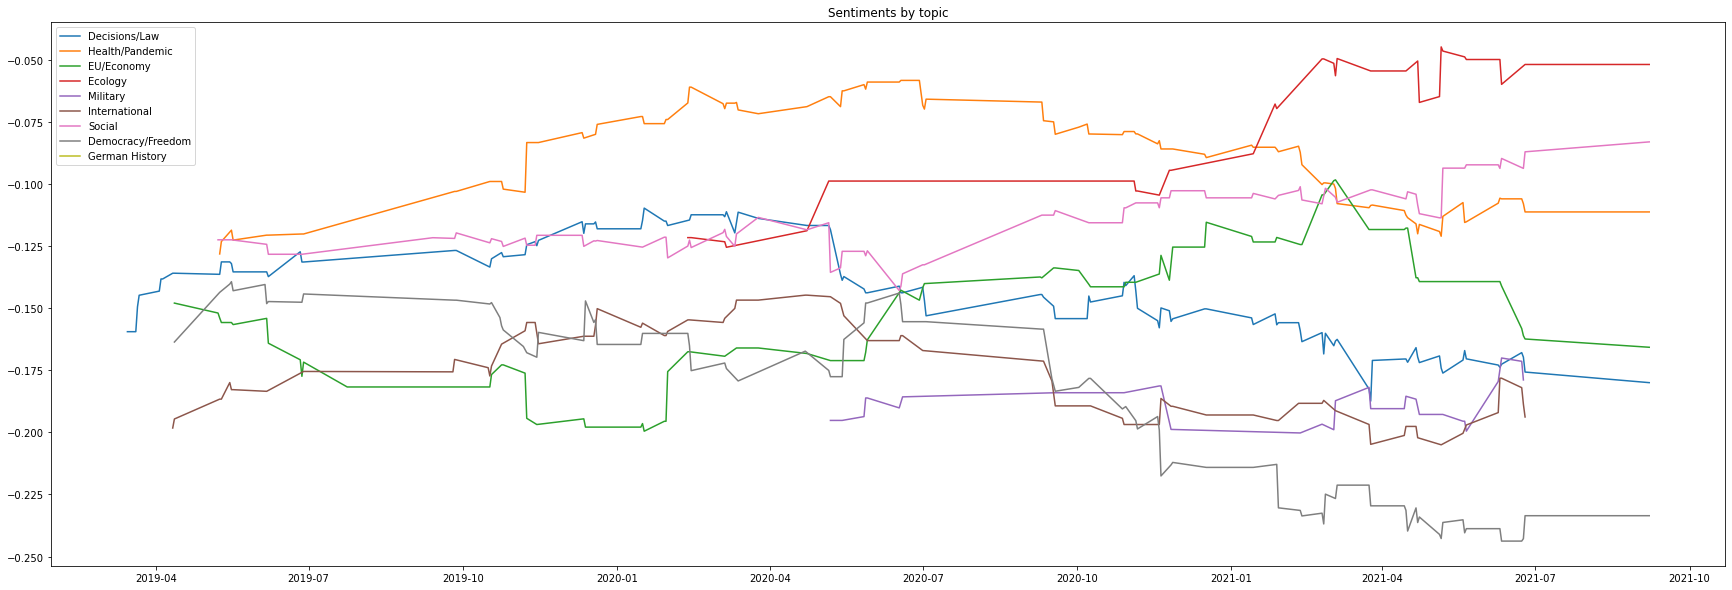

In [31]:
fig, ax = plt.subplots(figsize=(30, 10))
topics = merged_df['topic'].unique()

n_days = 50

for topic in topics:
    data = merged_df[merged_df['topic'] == topic]
    ax.plot(
        data['date'].unique()[n_days:],
        data.groupby('date').mean()['sentiment_num'].rolling(n_days).mean().tail(-n_days),
        label=topic)
ax.legend()
ax.set_title('Sentiments by topic')

### 2.3) Sentiments by party and topic

C:\Users\arthu\AppData\Local\Temp/ipykernel_18780/3219461975.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


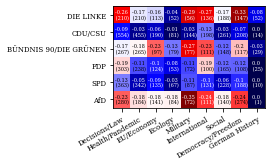

In [32]:
# Confusion matrix
fig = sentiments_plot(merged_df)
fig.show()
fig.savefig(os.path.join(images_path, 'sentiments_confusion.pdf'), bbox_inches='tight')

In [33]:
counts_df = merged_df[['sentiment', 'party', 'topic', 'date']].groupby(['sentiment', 'party', 'topic']).count().reset_index().rename(columns={'date': 'count'})
counts_df = counts_df.pivot(index=['topic', 'party'], columns='sentiment', values='count').fillna(0)
counts_df['total'] = counts_df['negative'] + counts_df['neutral'] + counts_df['positive']
counts_df

sentiment                                negative  neutral  positive  total
topic             party                                                    
Decisions/Law     AfD                        64.0    216.0       0.0  280.0
                  BÜNDNIS 90/DIE GRÜNEN      46.0    220.0       1.0  267.0
                  CDU/CSU                    51.0    502.0       1.0  554.0
                  DIE LINKE                  55.0    155.0       0.0  210.0
                  FDP                        57.0    246.0       0.0  303.0
                  SPD                        47.0    316.0       0.0  363.0
Democracy/Freedom AfD                        67.0    206.0       1.0  274.0
                  BÜNDNIS 90/DIE GRÜNEN      24.0     92.0       1.0  117.0
                  CDU/CSU                    17.0    189.0       2.0  208.0
                  DIE LINKE                  48.0     99.0       0.0  147.0
                  FDP                        13.0     95.0       0.0  108.0
                  SPD                        20.0    167.0       1.0  188.0
EU/Economy        AfD                        25.0    116.0       0.0  141.0
                  BÜNDNIS 90/DIE GRÜNEN      22.0     75.0       0.0   97.0
                  CDU/CSU                    11.0    179.0       0.0  190.0
                  DIE LINKE                  18.0     95.0       0.0  113.0
                  FDP                        12.0    112.0       0.0  124.0
                  SPD                        12.0    123.0       0.0  135.0
Ecology           AfD                        16.0     67.0       1.0   84.0
                  BÜNDNIS 90/DIE GRÜNEN      10.0     69.0       0.0   79.0
                  CDU/CSU                     1.0     80.0       0.0   81.0
                  DIE LINKE                   2.0     50.0       0.0   52.0
                  FDP                         4.0     49.0       0.0   53.0
                  SPD                         2.0     65.0       0.0   67.0
German History    AfD                         0.0      1.0       0.0    1.0
                  BÜNDNIS 90/DIE GRÜNEN       1.0     28.0       0.0   29.0
                  CDU/CSU                     0.0     14.0       0.0   14.0
                  DIE LINKE                   4.0     48.0       0.0   52.0
                  FDP                         0.0     25.0       0.0   25.0
                  SPD                         0.0     10.0       0.0   10.0
Health/Pandemic   AfD                        34.0    150.0       0.0  184.0
                  BÜNDNIS 90/DIE GRÜNEN      47.0    218.0       0.0  265.0
                  CDU/CSU                    16.0    438.0       1.0  455.0
                  DIE LINKE                  35.0    175.0       0.0  210.0
                  FDP                        27.0    211.0       0.0  238.0
                  SPD                        19.0    322.0       1.0  342.0
International     AfD                        27.0     84.0       0.0  111.0
                  BÜNDNIS 90/DIE GRÜNEN      26.0     85.0       0.0  111.0
                  CDU/CSU                    26.0    171.0       1.0  198.0
                  DIE LINKE                  37.0     99.0       0.0  136.0
                  FDP                        19.0     81.0       0.0  100.0
                  SPD                        13.0    118.0       0.0  131.0
Military          AfD                        25.0     47.0       0.0   72.0
                  BÜNDNIS 90/DIE GRÜNEN      22.0     54.0       1.0   77.0
                  CDU/CSU                     6.0    137.0       1.0  144.0
                  DIE LINKE                  16.0     40.0       0.0   56.0
                  FDP                         8.0     64.0       0.0   72.0
                  SPD                        10.0     77.0       0.0   87.0
Social            AfD                        25.0    115.0       0.0  140.0
                  BÜNDNIS 90/DIE GRÜNEN      18.0    130.0       0.0  148.0
                  CDU/CSU                     9.

In [34]:
# Prepare dataset for p-value testing
mean_df = counts_df.reset_index().groupby('topic').sum()
mean_df.rename(columns={'positive': 'cat_positive', 'negative': 'cat_negative', 'total': 'cat_total', 'neutral': 'cat_neutral'}, inplace=True)
counts_df = pd.merge(counts_df.reset_index(level=[1]), mean_df, left_on='topic', right_on='topic')
counts_df

sentiment,party,negative,neutral,positive,total,cat_negative,cat_neutral,cat_positive,cat_total
topic,,,,,,,,,
Decisions/Law,AfD,64.0,216.0,0.0,280.0,320.0,1655.0,2.0,1977.0
Decisions/Law,BÜNDNIS 90/DIE GRÜNEN,46.0,220.0,1.0,267.0,320.0,1655.0,2.0,1977.0
Decisions/Law,CDU/CSU,51.0,502.0,1.0,554.0,320.0,1655.0,2.0,1977.0
Decisions/Law,DIE LINKE,55.0,155.0,0.0,210.0,320.0,1655.0,2.0,1977.0
Decisions/Law,FDP,57.0,246.0,0.0,303.0,320.0,1655.0,2.0,1977.0
Decisions/Law,SPD,47.0,316.0,0.0,363.0,320.0,1655.0,2.0,1977.0
Democracy/Freedom,AfD,67.0,206.0,1.0,274.0,189.0,848.0,5.0,1042.0
Democracy/Freedom,BÜNDNIS 90/DIE GRÜNEN,24.0,92.0,1.0,117.0,189.0,848.0,5.0,1042.0
Democracy/Freedom,CDU/CSU,17.0,189.0,2.0,208.0,189.0,848.0,5.0,1042.0


In [35]:
# P-value testing
def p_value_lower(row):
    return betabinom.cdf(k=row['negative'], n=row['total'], a=row['cat_negative'], b=row['cat_positive']+row['cat_neutral'])

def p_value_higher(row):
    return 1 - betabinom.cdf(k=row['negative']-1, n=row['total'], a=row['cat_negative'], b=row['cat_positive']+row['cat_neutral'])

counts_df['p_value_lower'] = counts_df.apply(p_value_lower, axis=1)
counts_df['p_value_higher'] = counts_df.apply(p_value_higher, axis=1)

counts_df

sentiment,party,negative,neutral,positive,total,cat_negative,cat_neutral,cat_positive,cat_total,p_value_lower,p_value_higher
topic,,,,,,,,,,,
Decisions/Law,AfD,64.0,216.0,0.0,280.0,320.0,1655.0,2.0,1977.0,9.972447e-01,0.004162
Decisions/Law,BÜNDNIS 90/DIE GRÜNEN,46.0,220.0,1.0,267.0,320.0,1655.0,2.0,1977.0,7.013747e-01,0.353678
Decisions/Law,CDU/CSU,51.0,502.0,1.0,554.0,320.0,1655.0,2.0,1977.0,1.257277e-05,0.999993
Decisions/Law,DIE LINKE,55.0,155.0,0.0,210.0,320.0,1655.0,2.0,1977.0,9.998234e-01,0.000316
Decisions/Law,FDP,57.0,246.0,0.0,303.0,320.0,1655.0,2.0,1977.0,8.885486e-01,0.140035
Decisions/Law,SPD,47.0,316.0,0.0,363.0,320.0,1655.0,2.0,1977.0,6.664041e-02,0.949667
Democracy/Freedom,AfD,67.0,206.0,1.0,274.0,189.0,848.0,5.0,1042.0,9.914545e-01,0.011987
Democracy/Freedom,BÜNDNIS 90/DIE GRÜNEN,24.0,92.0,1.0,117.0,189.0,848.0,5.0,1042.0,7.760929e-01,0.294704
Democracy/Freedom,CDU/CSU,17.0,189.0,2.0,208.0,189.0,848.0,5.0,1042.0,1.249649e-04,0.999946


In [36]:
# Significant hypotheses (Bonferroni correction)
n_hypotheses = (counts_df.shape[0] * 2)
alpha = 0.05
counts_df['significantly_lower'] = counts_df['p_value_lower'] < (alpha / n_hypotheses)
counts_df['significantly_higher'] = counts_df['p_value_higher'] < (alpha / n_hypotheses)
counts_df[(counts_df['significantly_lower']) + (counts_df['significantly_higher'])]

sentiment,party,negative,neutral,positive,total,cat_negative,cat_neutral,cat_positive,cat_total,p_value_lower,p_value_higher,significantly_lower,significantly_higher
topic,,,,,,,,,,,,,
Decisions/Law,CDU/CSU,51.0,502.0,1.0,554.0,320.0,1655.0,2.0,1977.0,1.257277e-05,0.999993,True,False
Decisions/Law,DIE LINKE,55.0,155.0,0.0,210.0,320.0,1655.0,2.0,1977.0,9.998234e-01,0.000316,False,True
Democracy/Freedom,CDU/CSU,17.0,189.0,2.0,208.0,189.0,848.0,5.0,1042.0,1.249649e-04,0.999946,True,False
Democracy/Freedom,DIE LINKE,48.0,99.0,0.0,147.0,189.0,848.0,5.0,1042.0,9.999705e-01,0.000060,False,True
Health/Pandemic,CDU/CSU,16.0,438.0,1.0,455.0,178.0,1514.0,2.0,1694.0,3.758465e-07,1.000000,True,False
Military,CDU/CSU,6.0,137.0,1.0,144.0,87.0,419.0,2.0,508.0,1.412584e-05,0.999996,True,False
Social,CDU/CSU,9.0,252.0,0.0,261.0,117.0,1013.0,0.0,1130.0,1.079656e-04,0.999963,True,False


### 2.4) Sentiment by party

In [37]:
grouped_counts_df = counts_df[['party', 'negative', 'neutral', 'positive', 'total']].groupby('party').sum()
grouped_counts_df['all_negative'] = np.sum(grouped_counts_df['negative'])
grouped_counts_df['all_neutral'] = np.sum(grouped_counts_df['neutral'])
grouped_counts_df['all_positive'] = np.sum(grouped_counts_df['positive'])

def p_value_lower(row):
    return betabinom.cdf(k=row['negative'], n=row['total'], a=row['all_negative'], b=row['all_positive']+row['all_neutral'])

def p_value_higher(row):
    return 1 - betabinom.cdf(k=row['negative']-1, n=row['total'], a=row['all_negative'], b=row['all_positive']+row['all_neutral'])

grouped_counts_df['p_value_lower'] = grouped_counts_df.apply(p_value_lower, axis=1)
grouped_counts_df['p_value_higher'] = grouped_counts_df.apply(p_value_higher, axis=1)

n_hypotheses = (grouped_counts_df.shape[0] * 2)
alpha = 0.05
print(alpha/n_hypotheses)

grouped_counts_df['significantly_lower'] = grouped_counts_df['p_value_lower'] < (alpha / n_hypotheses)
grouped_counts_df['significantly_higher'] = grouped_counts_df['p_value_higher'] < (alpha / n_hypotheses)
grouped_counts_df[(grouped_counts_df['significantly_lower']) + (grouped_counts_df['significantly_higher'])]

0.004166666666666667


sentiment,negative,neutral,positive,total,all_negative,all_neutral,all_positive,p_value_lower,p_value_higher,significantly_lower,significantly_higher
party,,,,,,,,,,,
AfD,283.0,1002.0,2.0,1287.0,1179.0,7293.0,13.0,1.000000e+00,1.395717e-11,False,True
BÜNDNIS 90/DIE GRÜNEN,216.0,971.0,3.0,1190.0,1179.0,7293.0,13.0,9.999418e-01,7.791025e-05,False,True
CDU/CSU,137.0,1962.0,6.0,2105.0,1179.0,7293.0,13.0,7.298842e-23,1.000000e+00,True,False
DIE LINKE,247.0,917.0,0.0,1164.0,1179.0,7293.0,13.0,1.000000e+00,1.657661e-10,False,True
SPD,136.0,1413.0,2.0,1551.0,1179.0,7293.0,13.0,5.925735e-09,1.000000e+00,True,False
